## Project Overview
### Objective:
The main goal of this project is to process and analyze time-series data from wearable sensors (like accelerometers and EDA sensors) to compare three different versions of the data:

1. Raw Data: The original high-frequency data collected directly from the sensors.
2. Kalman-Smoothed Data: The raw data processed through a Kalman filter to reduce noise and smooth the signal.
3. Minute-Averaged Data: The raw data aggregated by calculating the average value for each minute.

## Outcome:
By plotting these three versions on the same graph, you can visually compare how the data changes with each processing step.

## Understanding the Data Files
1. Avro Files (.avro files):
Avro files are a way to store complex data structures in a compact binary format. They are commonly used for serializing data in big data environments. In this project, the Avro files contain the raw sensor data, including accelerometer and EDA readings, along with metadata like timestamps and sampling frequencies.

2. CSV Files (.csv files):
CSV files are plain text files that store tabular data. In your project, they contain the minute-averaged data. The CSV files in the digital_biomarkers/aggregated_per_minute/ directory hold** pre-processed data where each value represents the average sensor reading over one minute.


In [ ]:
!pip install numpy matplotlib pandas filterpy fastavro
!pip install avro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 50.6 MB/s eta 0:00:00
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=05d98bc0b6284f66924d27256d706c67a933462baafd68a52f2cbd3b98ea06a3
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 kB 5.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from fastavro import reader
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

In [ ]:
# Path to .avro file
avro_file = "/content/drive/MyDrive/dataseta/raw_data/1-1-00004_1733266839.avro"

# Open and inspect the .avro file
with open(avro_file, 'rb') as f:
    avro_reader = reader(f)
    for record in avro_reader:
        print(record.keys())  # Top-level keys
        print(record["rawData"].keys())  # Keys inside "rawData"
        print(record["rawData"]["accelerometer"].keys())  # Keys for accelerometer
        break  # Only inspect the first record

dict_keys(['schemaVersion', 'fwVersion', 'hwVersion', 'algoVersion', 'timezone', 'enrollment', 'deviceSn', 'deviceModel', 'rawData'])
dict_keys(['accelerometer', 'gyroscope', 'eda', 'temperature', 'tags', 'bvp', 'systolicPeaks', 'steps'])
dict_keys(['timestampStart', 'samplingFrequency', 'imuParams', 'x', 'y', 'z'])


In [ ]:
# Open and inspect the .avro file
with open(avro_file, 'rb') as f:
    avro_reader = reader(f)
    for record in avro_reader:
        print(record.keys())  # Top-level keys
        print(record["rawData"].keys())  # Keys inside "rawData"
        print(record["rawData"]["eda"].keys())  # Keys for accelerometer
        break  # Only inspect the first record

dict_keys(['schemaVersion', 'fwVersion', 'hwVersion', 'algoVersion', 'timezone', 'enrollment', 'deviceSn', 'deviceModel', 'rawData'])
dict_keys(['accelerometer', 'gyroscope', 'eda', 'temperature', 'tags', 'bvp', 'systolicPeaks', 'steps'])
dict_keys(['timestampStart', 'samplingFrequency', 'values'])


In [ ]:
def load_raw_avro_data(file_path, key):

    with open(file_path, "rb") as f:
        avro_reader = reader(f)
        for record in avro_reader:
            data = record["rawData"][key]  # Access specific data (accelerometer/EDA)

            # For Accelerometer Data
            if key == "accelerometer":
                x = np.array(data["x"])  # X-axis data
                y = np.array(data["y"])  # Y-axis data
                z = np.array(data["z"])  # Z-axis data
                sr = data["samplingFrequency"]  # Sampling frequency
                timestamps = np.arange(0, len(x)) / sr + data["timestampStart"] / 1e6
                timestamps = [datetime.utcfromtimestamp(ts) for ts in timestamps]
                values = np.sqrt(x**2 + y**2 + z**2)  # Magnitude of acceleration
                return values, timestamps

            # For EDA Data
            elif key == "eda":
                eda_values = np.array(data["values"])  # Use the "values" key
                sr = data["samplingFrequency"]
                timestamps = np.arange(0, len(eda_values)) / sr + data["timestampStart"] / 1e6
                timestamps = [datetime.utcfromtimestamp(ts) for ts in timestamps]
                return eda_values, timestamps

In [ ]:
# Define file paths
raw_data_path = "/content/drive/MyDrive/dataseta/raw_data/"
acc_file = raw_data_path + "1-1-00004_1733266839.avro"
eda_file = raw_data_path + "1-1-00004_1733266839.avro"

# Load Accelerometer Data
acc_raw, time_acc_raw = load_raw_avro_data(acc_file, "accelerometer")

# Load EDA Data
eda_raw, time_eda_raw = load_raw_avro_data(eda_file, "eda")


In [ ]:
# Create DataFrame for Raw Accelerometer Data
acc_df = pd.DataFrame({
    "time_acc": time_acc_raw,
    "acc_raw": acc_raw
})

# Create DataFrame for Raw EDA Data
eda_df = pd.DataFrame({
    "time_eda": time_eda_raw,
    "eda_raw": eda_raw
})

In [ ]:
acc_df.head()

,time_acc,acc_raw
0,2024-12-03 23:00:39.652037,1874.259587
1,2024-12-03 23:00:39.667622,2174.699060
2,2024-12-03 23:00:39.683207,2017.296210
3,2024-12-03 23:00:39.698792,1815.648644
4,2024-12-03 23:00:39.714377,2125.687418


In [ ]:
eda_df.head()

,time_eda,eda_raw
0,2024-12-03 23:00:39.880339,0.026531
1,2024-12-03 23:00:40.124222,0.028234
2,2024-12-03 23:00:40.368104,0.027267
3,2024-12-03 23:00:40.611987,0.028104
4,2024-12-03 23:00:40.855870,0.029518


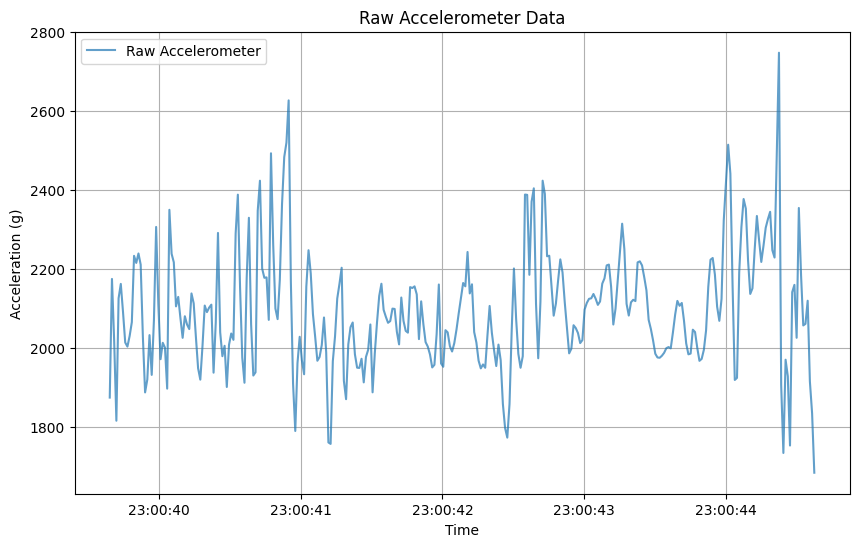

In [ ]:
# Plot Raw Accelerometer Data
plt.figure(figsize=(10, 6))
plt.plot(acc_df["time_acc"], acc_df["acc_raw"], label="Raw Accelerometer", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Acceleration (g)")
plt.title("Raw Accelerometer Data")
plt.legend()
plt.grid(True)
plt.show()

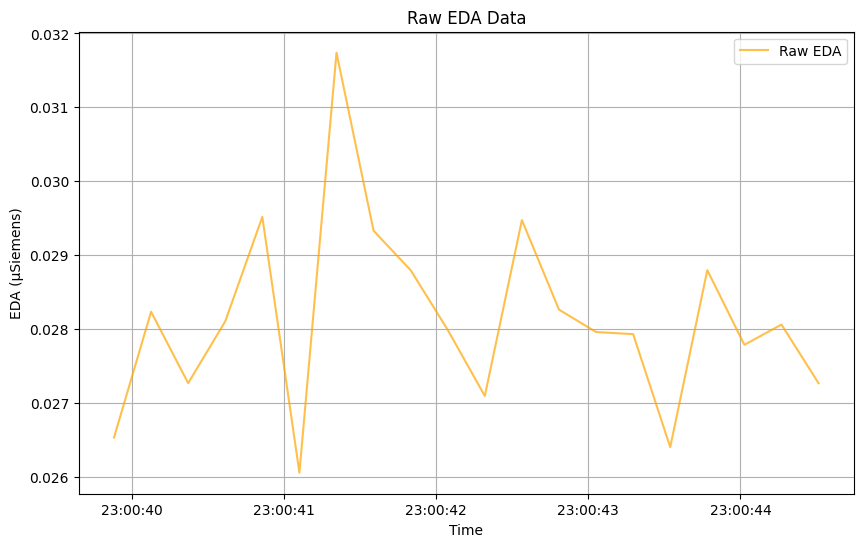

In [ ]:
# Plot Raw EDA Data
plt.figure(figsize=(10, 6))
plt.plot(eda_df["time_eda"], eda_df["eda_raw"], label="Raw EDA", color="orange", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("EDA (μSiemens)")
plt.title("Raw EDA Data")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def apply_kalman_filter(data):

    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([0., 0.])  # Initial state (position and velocity)
    kf.F = np.array([[1., 1.], [0., 1.]])  # State transition matrix
    kf.H = np.array([[1., 0.]])  # Measurement function
    kf.P *= 1000.  # Covariance matrix
    kf.R = 5  # Measurement noise
    kf.Q = np.eye(2)  # Process noise

    smoothed_data = []
    for measurement in data:
        kf.predict()
        kf.update(measurement)
        smoothed_data.append(kf.x[0])
    return smoothed_data

In [ ]:
# Apply Kalman filter to accelerometer and EDA data

acc_df["acc_smoothed"] = apply_kalman_filter(acc_df["acc_raw"].values)
eda_df["eda_smoothed"] = apply_kalman_filter(eda_df["eda_raw"].values)

In [ ]:
eda_df.head()

,time_eda,eda_raw,eda_smoothed
0,2024-12-03 23:00:39.880339,0.026531,0.026465
1,2024-12-03 23:00:40.124222,0.028234,0.028344
2,2024-12-03 23:00:40.368104,0.027267,0.027753
3,2024-12-03 23:00:40.611987,0.028104,0.028132
4,2024-12-03 23:00:40.855870,0.029518,0.029218


In [ ]:
acc_df.head()

,time_acc,acc_raw,acc_smoothed
0,2024-12-03 23:00:39.652037,1874.259587,1869.587953
1,2024-12-03 23:00:39.667622,2174.699060,2180.767087
2,2024-12-03 23:00:39.683207,2017.296210,2092.297576
3,2024-12-03 23:00:39.698792,1815.648644,1905.333011
4,2024-12-03 23:00:39.714377,2125.687418,2042.267058


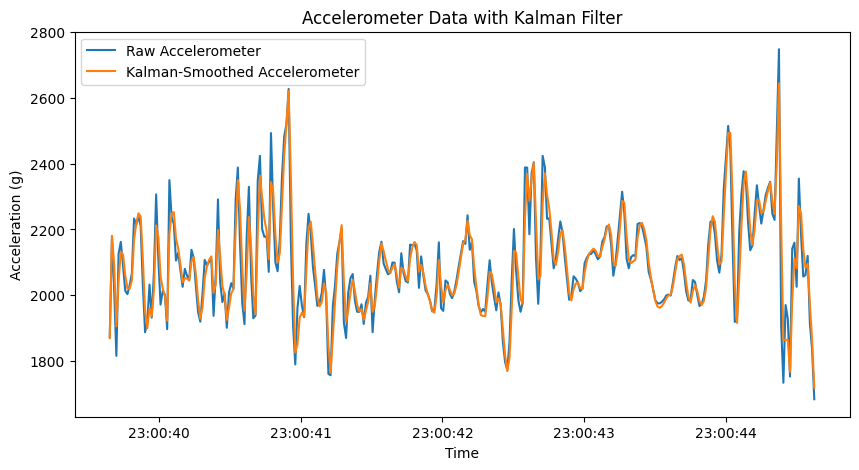

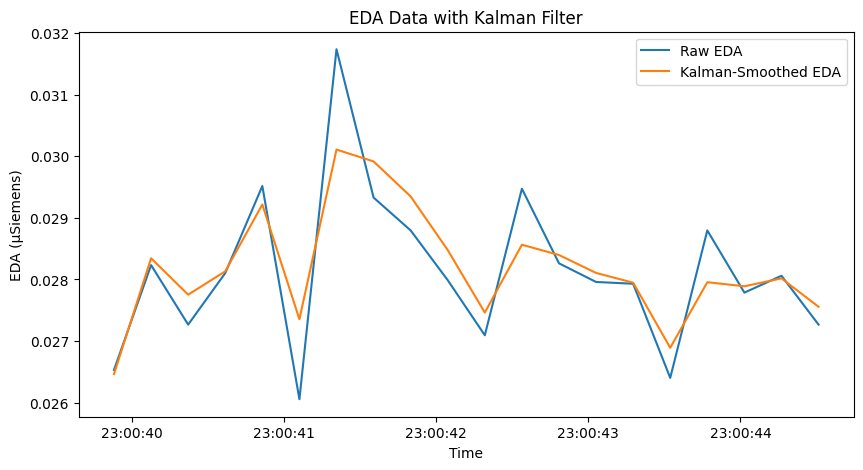

In [ ]:
# Plot accelerometer data
plt.figure(figsize=(10, 5))
plt.plot(acc_df["time_acc"], acc_df["acc_raw"], label="Raw Accelerometer")
plt.plot(acc_df["time_acc"], acc_df["acc_smoothed"], label="Kalman-Smoothed Accelerometer")
plt.legend()
plt.title("Accelerometer Data with Kalman Filter")
plt.xlabel("Time")
plt.ylabel("Acceleration (g)")
plt.show()

# Plot EDA data
plt.figure(figsize=(10, 5))
plt.plot(eda_df["time_eda"], eda_df["eda_raw"], label="Raw EDA")
plt.plot(eda_df["time_eda"], eda_df["eda_smoothed"], label="Kalman-Smoothed EDA")
plt.legend()
plt.title("EDA Data with Kalman Filter")
plt.xlabel("Time")
plt.ylabel("EDA (μSiemens)")
plt.show()


In [ ]:
acc_df

,time_acc,acc_raw,acc_smoothed
0,2024-12-03 23:00:39.652037,1874.259587,1869.587953
1,2024-12-03 23:00:39.667622,2174.699060,2180.767087
2,2024-12-03 23:00:39.683207,2017.296210,2092.297576
3,2024-12-03 23:00:39.698792,1815.648644,1905.333011
4,2024-12-03 23:00:39.714377,2125.687418,2042.267058
...,...,...,...
315,2024-12-03 23:00:44.561325,2060.941532,2083.246169
316,2024-12-03 23:00:44.576910,2119.517634,2095.745257
317,2024-12-03 23:00:44.592495,1915.100781,1973.074558
318,2024-12-03 23:00:44.608080,1834.724502,1862.688753


In [ ]:
# Paths to processed data files
acc_processed_path = "/content/drive/MyDrive/dataseta/processed_data/1-1-00004_2024-12-03_accelerometers-std.csv"
eda_processed_path = "/content/drive/MyDrive/dataseta/processed_data/1-1-00004_2024-12-03_eda.csv"

# Load data
acc_processed_df = pd.read_csv(acc_processed_path)
eda_processed_df = pd.read_csv(eda_processed_path)


In [ ]:
acc_processed_df.head()

,timestamp_unix,timestamp_iso,participant_full_id,accelerometers_std_g,missing_value_reason
0,1733184000000,2024-12-03T00:00:00Z,1331-1-1-00004,NaN,device_not_recording
1,1733184060000,2024-12-03T00:01:00Z,1331-1-1-00004,NaN,device_not_recording
2,1733184120000,2024-12-03T00:02:00Z,1331-1-1-00004,NaN,device_not_recording
3,1733184180000,2024-12-03T00:03:00Z,1331-1-1-00004,NaN,device_not_recording
4,1733184240000,2024-12-03T00:04:00Z,1331-1-1-00004,NaN,device_not_recording


In [ ]:
acc_processed_df['accelerometers_std_g'].values

array([nan, nan, nan, ..., nan, nan, nan])

In [ ]:

eda_processed_df.head()

,timestamp_unix,timestamp_iso,participant_full_id,eda_scl_usiemens,missing_value_reason
0,1733184000000,2024-12-03T00:00:00Z,1331-1-1-00004,NaN,device_not_recording
1,1733184060000,2024-12-03T00:01:00Z,1331-1-1-00004,NaN,device_not_recording
2,1733184120000,2024-12-03T00:02:00Z,1331-1-1-00004,NaN,device_not_recording
3,1733184180000,2024-12-03T00:03:00Z,1331-1-1-00004,NaN,device_not_recording
4,1733184240000,2024-12-03T00:04:00Z,1331-1-1-00004,NaN,device_not_recording


In [ ]:
# Ensure 'time_acc' column is in datetime format
acc_df['time_acc'] = pd.to_datetime(acc_df['time_acc'])

In [ ]:
acc_df

,time_acc,acc_raw,acc_smoothed
0,2024-12-03 23:00:39.652037,1874.259587,1869.587953
1,2024-12-03 23:00:39.667622,2174.699060,2180.767087
2,2024-12-03 23:00:39.683207,2017.296210,2092.297576
3,2024-12-03 23:00:39.698792,1815.648644,1905.333011
4,2024-12-03 23:00:39.714377,2125.687418,2042.267058
...,...,...,...
315,2024-12-03 23:00:44.561325,2060.941532,2083.246169
316,2024-12-03 23:00:44.576910,2119.517634,2095.745257
317,2024-12-03 23:00:44.592495,1915.100781,1973.074558
318,2024-12-03 23:00:44.608080,1834.724502,1862.688753


In [ ]:
# Generate 1-minute averaged data
minute_avg_acc = acc_df.resample('1T', on='time_acc').mean().reset_index()

<ipython-input-26-a7de57625637>:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  minute_avg_acc = acc_df.resample('1T', on='time_acc').mean().reset_index()


In [ ]:
print("Start time:", acc_df['time_acc'].min())
print("End time:", acc_df['time_acc'].max())
print("Duration:", acc_df['time_acc'].max() - acc_df['time_acc'].min())


Start time: 2024-12-03 23:00:39.652037
End time: 2024-12-03 23:00:44.623665
Duration: 0 days 00:00:04.971628


In [ ]:
# Align Raw and Smoothed Data to 1-Minute Timestamps
# Resample raw data
acc_raw_resampled = acc_df[['time_acc', 'acc_raw']].set_index('time_acc').resample('1T').mean()
acc_raw_resampled = acc_raw_resampled.reset_index()

# Resample smoothed data
acc_smooth_resampled = acc_df[['time_acc', 'acc_smoothed']].set_index('time_acc').resample('1T').mean()
acc_smooth_resampled = acc_smooth_resampled.reset_index()

# Step 3: Combine All Three into a Single DataFrame
combined_df = pd.merge(minute_avg_acc, acc_raw_resampled, on='time_acc', how='left', suffixes=('', '_raw_resampled'))
combined_df = pd.merge(combined_df, acc_smooth_resampled, on='time_acc', how='left', suffixes=('', '_smooth_resampled'))

,time_acc,acc_raw,acc_smoothed,acc_raw_raw_resampled,acc_smoothed_smooth_resampled
0,2024-12-03 23:00:00,2093.912474,2094.730149,2093.912474,2094.730149


In [ ]:
# Rename for clarity
combined_df.rename(columns={
    'acc_raw': 'Minute-Averaged',
    'acc_raw_resampled': 'Raw',
    'acc_smoothed': 'Kalman-Smoothed'
}, inplace=True)

# Step 4: Plot All Three Lines Together
plt.figure(figsize=(12, 6))

# Plot Raw Data
plt.plot(combined_df['time_acc'], combined_df['Raw'], label='Raw', linewidth=1)

# Plot Kalman-Smoothed Data
plt.plot(combined_df['time_acc'], combined_df['Kalman-Smoothed'], label='Kalman-Smoothed', linewidth=1)

# Plot Minute-Averaged Data
plt.plot(combined_df['time_acc'], combined_df['Minute-Averaged'], label='Minute-Averaged', linestyle='--', linewidth=2)

plt.xlabel('Time [HH:MM:SS]')
plt.ylabel('Acceleration (g)')
plt.title('Comparison of Raw, Kalman-Smoothed, and Minute-Averaged Accelerometer Data')
plt.legend()
plt.grid()
plt.show()
